# GRU Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import random
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from torcheval.metrics.functional import (
    multilabel_accuracy,
    multilabel_precision_recall_curve,
)

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("scripts")
from scripts.steam_review_dataset import SteamReviewDataset
from scripts.annotations import update_df_review_labels

In [3]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [5]:
# Lade die Daten
df = pd.read_csv("../data/reviews_100k_cleaned_new.csv.bz2")

# Lade labels
llm_notation_file = (
    "./scripts/results/results-v2-2025-02-03T19_58_54.749839-nall-llama3.2.json"
)

with open(llm_notation_file, "r") as fi:
    review_id_with_topics = {
        int(k): v for k, v in json.load(fi).items()
    }  # str keys to int

df, topics = update_df_review_labels(df, review_id_with_topics, dropna=True)

print(f"Found {len(topics)} topics: {topics}\n")
print(df.info())
print("\nTopic distribution:")
print(df.iloc[:, -12:].sum())

Found 12 topics: ['gamemode', 'story', 'support', 'hardware_requirements', 'online_play', 'gameplay', 'bugs', 'seasonal_content', 'price', 'updates', 'visuals', 'sound']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_id              218 non-null    int64  
 1   review                 218 non-null    object 
 2   voted_up               218 non-null    bool   
 3   votes_up               218 non-null    int64  
 4   weighted_vote_score    218 non-null    float64
 5   app_id                 218 non-null    int64  
 6   gamemode               218 non-null    float64
 7   story                  218 non-null    float64
 8   support                218 non-null    float64
 9   hardware_requirements  218 non-null    float64
 10  online_play            218 non-null    float64
 11  gameplay               218 non-null    floa

In [6]:
# Aufteilen in Train+Validation und Test (80/20 Split)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,  # TODO stratify causes issues with multilabel targets
)

# Aufteilen von Train+Validation in Training und Validation (75/25 von Train+Val)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

# Überprüfe die Größe der Splits
print(f"Original size: {len(df)}")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Original size: 218
Train size: 130
Validation size: 44
Test size: 44


In [7]:
# Erstelle Dataset-Objekte
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
max_len = 200  # 91% der Reviews haben weniger als 200 Tokens
batch_size = 4

train_dataset = SteamReviewDataset(
    data=train_df,
    tokenizer=tokenizer,
    max_len=max_len,
    topic_mode=True,
    topics=topics,
)
val_dataset = SteamReviewDataset(
    data=val_df,
    tokenizer=tokenizer,
    max_len=max_len,
    topic_mode=True,
    topics=topics,
)
test_dataset = SteamReviewDataset(
    data=test_df,
    tokenizer=tokenizer,
    max_len=max_len,
    topic_mode=True,
    topics=topics,
)

# Erstelle DataLoader für jeden Split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Batch Shape
for tokens, topics_onehot in train_loader:
    print(f"Tokens shape: {tokens.shape}, Labels shape: {topics_onehot.shape}")
    break

print(train_dataset[0])

Tokens shape: torch.Size([4, 200]), Labels shape: torch.Size([4, 12])
(tensor([  10,   15,   20,    9,   94,   12,  580,    8,    6, 1392,   12,  113,
          15,   38,   50,   27, 2438,  163, 2160,    6,   38,   50, 1451,   27,
          75,   27,   14,    8,   15,  286,  158,   11,    6,   53,   20,   21,
         490,   32,    5,    9,  691,   12,    9, 2065,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,

In [8]:
class GRUClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        gru_layers: int,
        hidden_dim: int,
        dropout: float,
        output_dim: int,
        pad_idx: int,
    ):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_idx
        )
        self.gru = nn.GRU(
            input_size=embedding_dim,
            num_layers=gru_layers,
            hidden_size=hidden_dim,
            dropout=dropout if gru_layers > 1 else 0,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)

        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_dim)

        last_hidden_state = gru_out[:, -1, :]  # (batch_size, hidden_dim)

        output = self.fc(last_hidden_state)  # (batch_size, output_dim)

        return output

In [9]:
from sklearn.metrics import jaccard_score


def train_model(
    model: GRUClassifier,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    lr: float,
    device=torch.device("cpu"),
):
    # Loss und Optimizer definieren
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4, fused=False)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=1
    )

    model.to(device)

    print(f"Start training on device '{device}'")

    # Early Stopping Parameter
    patience = 10
    patience_counter = 0
    best_val_accuracy = 0.0
    best_model_state = None
    last_epoch = 0

    # Listen für Visualisierung
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training und Validation Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_labels = []
        train_preds = []

        train_progress = tqdm(
            train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", ncols=100
        )

        epoch_start_time = time.time()  # Startzeit für die Epoche

        # Trainingsloop
        for batch in train_progress:
            tokens, topics_onehot = batch

            tokens, topics_onehot = tokens.to(device), topics_onehot.to(device)

            # Forward Pass
            optimizer.zero_grad()
            outputs = model(tokens)

            loss = criterion(outputs, topics_onehot)

            # Backward Pass und Optimierung
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

            # Berechne Predictions und füge sie zur Liste hinzu
            probabilities = torch.sigmoid(outputs)
            threshold = 0.5
            train_preds += (probabilities >= threshold).cpu().int().numpy().tolist()
            train_labels += topics_onehot.cpu().int().numpy().tolist()

            # Update TQDM mit dem aktuellen Loss
            train_progress.set_postfix(
                loss=f"{running_loss / (train_progress.n + 1):.3f}"
            )

        # Berechne Trainings-Accuracy
        print(
            "Jac Samples:",
            jaccard_score(
                train_labels, train_preds, average="samples", zero_division=1
            ),
        )
        print("Jac Micro:", jaccard_score(train_labels, train_preds, average="micro"))
        print("Jac Macro:", jaccard_score(train_labels, train_preds, average="macro"))
        print(
            f"Train Accuracy:",
            multilabel_accuracy(
                torch.tensor(train_preds),
                torch.tensor(train_labels),
                criteria="hamming",
            ).item(),
        )

        train_accuracy = jaccard_score(
            train_labels, train_preds, average="samples", zero_division=1
        )

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validierung
        model.eval()
        val_loss = 0.0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for batch in val_loader:
                tokens, topics_onehot = batch
                tokens, topics_onehot = tokens.to(device), topics_onehot.to(device)

                outputs = model(tokens)
                loss = criterion(outputs.squeeze(), topics_onehot)
                val_loss += loss.item()

                probabilities = torch.sigmoid(outputs)
                threshold = 0.5
                val_preds += (probabilities >= threshold).cpu().int().numpy().tolist()
                val_labels += topics_onehot.cpu().int().numpy().tolist()

        scheduler.step(val_loss)  # Scheduler mit Validierungs-Loss aufrufen

        # Berechne Validierungs-Accuracy
        val_accuracy = jaccard_score(
            val_labels, val_preds, average="samples", zero_division=1
        )

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        mins, secs = divmod(epoch_duration, 60)

        print(
            "├ "
            f"Train Loss: {running_loss/len(train_loader):.4f}, "
            f"Train Accuracy: {train_accuracy:.4f}, "
            f"Validation Loss: {val_loss/len(val_loader):.4f}, "
            f"Validation Accuracy: {val_accuracy:.4f}, "
            f"Time: {int(mins):2}:{secs:.2f}m"
        )

        # Early Stopping Überprüfung
        if val_accuracy > best_val_accuracy:
            print(
                f"└ Validation accuracy improved: {best_val_accuracy:.4f} → {val_accuracy:.4f}"
            )
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict()  # Speichere das beste Modell
            last_epoch = epoch
        else:
            patience_counter += 1
            print(
                f"└ No improvement in validation accuracy. "
                f"Patience counter: {patience_counter}/{patience}. Using LR: {scheduler.get_last_lr()[0]:.1e}",
            )
            # Überprüfe, ob Early Stopping ausgelöst werden soll
            if patience_counter >= patience:
                print(
                    "Early stopping triggered! "
                    f"Best Validation Accuracy: {best_val_accuracy:.2f}, on epoch {last_epoch+1}"
                )
                break

    # Lade das beste Modell zurück, falls Early Stopping ausgelöst wurde
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(
        f"Finished Training: Best Validation Accuracy: {best_val_accuracy:.2f}, on epoch {last_epoch+1}"
    )

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [10]:
# Lade den Tokenizer, um `vocab_size` und `pad_id` zu erhalten
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
vocab_size = tokenizer.get_piece_size()
pad_idx = tokenizer.pad_id()

# Modellparameter
embedding_dim = 512
gru_layers = 2
hidden_dim = 1024
output_dim = len(topics)
dropout = 0.5

# Initialisiere das GRU-Modell
model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    gru_layers=gru_layers,
    hidden_dim=hidden_dim,
    dropout=dropout,
    output_dim=output_dim,
    pad_idx=pad_idx,
)
print(model)

GRUClassifier(
  (embedding): Embedding(4000, 512, padding_idx=0)
  (gru): GRU(512, 1024, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=12, bias=True)
)


In [11]:
# Trainiere das Modell
epochs = 100
lr = 0.001

trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    device=device,
)

Start training on device 'cuda'


Epoch [1/100]: 100%|████████████████████████████████████| 33/33 [00:01<00:00, 20.39it/s, loss=0.411]


Jac Samples: 0.2806593406593406
Jac Micro: 0.2113564668769716
Jac Macro: 0.06583828812089682
Train Accuracy: 0.8397436141967773
├ Train Loss: 0.3984, Train Accuracy: 0.2807, Validation Loss: 0.4510, Validation Accuracy: 0.2564, Time:  0:1.85m
└ Validation accuracy improved: 0.0000 → 0.2564


Epoch [2/100]: 100%|████████████████████████████████████| 33/33 [00:01<00:00, 24.58it/s, loss=0.385]


Jac Samples: 0.3405128205128205
Jac Micro: 0.2987012987012987
Jac Macro: 0.08282749239106997
Train Accuracy: 0.8615384697914124
├ Train Loss: 0.3620, Train Accuracy: 0.3405, Validation Loss: 0.3782, Validation Accuracy: 0.2746, Time:  0:1.55m
└ Validation accuracy improved: 0.2564 → 0.2746


Epoch [3/100]: 100%|████████████████████████████████████| 33/33 [00:01<00:00, 24.52it/s, loss=0.338]


Jac Samples: 0.2976923076923077
Jac Micro: 0.2339622641509434
Jac Macro: 0.06992461392867898
Train Accuracy: 0.8698717951774597
├ Train Loss: 0.3180, Train Accuracy: 0.2977, Validation Loss: 0.4131, Validation Accuracy: 0.2519, Time:  0:1.55m
└ No improvement in validation accuracy. Patience counter: 1/10. Using LR: 1.0e-03


Epoch [4/100]: 100%|████████████████████████████████████| 33/33 [00:01<00:00, 24.77it/s, loss=0.319]


Jac Samples: 0.34512820512820513
Jac Micro: 0.28413284132841327
Jac Macro: 0.0955654159142531
Train Accuracy: 0.8756410479545593
├ Train Loss: 0.2999, Train Accuracy: 0.3451, Validation Loss: 0.4088, Validation Accuracy: 0.2462, Time:  0:1.54m
└ No improvement in validation accuracy. Patience counter: 2/10. Using LR: 1.0e-04


Epoch [5/100]: 100%|████████████████████████████████████| 33/33 [00:01<00:00, 24.06it/s, loss=0.299]


Jac Samples: 0.39384615384615385
Jac Micro: 0.35
Jac Macro: 0.12413479052823313
Train Accuracy: 0.8833333253860474
├ Train Loss: 0.2809, Train Accuracy: 0.3938, Validation Loss: 0.3959, Validation Accuracy: 0.2197, Time:  0:1.57m
└ No improvement in validation accuracy. Patience counter: 3/10. Using LR: 1.0e-04


Epoch [6/100]: 100%|████████████████████████████████████| 33/33 [00:01<00:00, 24.08it/s, loss=0.287]


Jac Samples: 0.4464102564102564
Jac Micro: 0.3474903474903475
Jac Macro: 0.12359317710824169
Train Accuracy: 0.8916666507720947
├ Train Loss: 0.2697, Train Accuracy: 0.4464, Validation Loss: 0.3997, Validation Accuracy: 0.2121, Time:  0:1.57m
└ No improvement in validation accuracy. Patience counter: 4/10. Using LR: 1.0e-05


Epoch [7/100]: 100%|████████████████████████████████████| 33/33 [00:01<00:00, 24.04it/s, loss=0.280]


Jac Samples: 0.47397435897435897
Jac Micro: 0.36220472440944884
Jac Macro: 0.13186377224596987
Train Accuracy: 0.8961538672447205
├ Train Loss: 0.2629, Train Accuracy: 0.4740, Validation Loss: 0.3995, Validation Accuracy: 0.2121, Time:  0:1.57m
└ No improvement in validation accuracy. Patience counter: 5/10. Using LR: 1.0e-05


Epoch [8/100]: 100%|████████████████████████████████████| 33/33 [00:01<00:00, 24.10it/s, loss=0.279]


Jac Samples: 0.47012820512820513
Jac Micro: 0.36470588235294116
Jac Macro: 0.1320916984680051
Train Accuracy: 0.8961538672447205
├ Train Loss: 0.2622, Train Accuracy: 0.4701, Validation Loss: 0.3996, Validation Accuracy: 0.2083, Time:  0:1.57m
└ No improvement in validation accuracy. Patience counter: 6/10. Using LR: 1.0e-06


Epoch [9/100]: 100%|████████████████████████████████████| 33/33 [00:01<00:00, 24.07it/s, loss=0.281]


Jac Samples: 0.47717948717948716
Jac Micro: 0.36220472440944884
Jac Macro: 0.13069035844997626
Train Accuracy: 0.8961538672447205
├ Train Loss: 0.2643, Train Accuracy: 0.4772, Validation Loss: 0.3996, Validation Accuracy: 0.2083, Time:  0:1.57m
└ No improvement in validation accuracy. Patience counter: 7/10. Using LR: 1.0e-06


Epoch [10/100]: 100%|███████████████████████████████████| 33/33 [00:01<00:00, 24.08it/s, loss=0.280]


Jac Samples: 0.4739743589743589
Jac Micro: 0.3657587548638132
Jac Macro: 0.13324816105303908
Train Accuracy: 0.8955128192901611
├ Train Loss: 0.2628, Train Accuracy: 0.4740, Validation Loss: 0.3997, Validation Accuracy: 0.2083, Time:  0:1.57m
└ No improvement in validation accuracy. Patience counter: 8/10. Using LR: 1.0e-07


Epoch [11/100]: 100%|███████████████████████████████████| 33/33 [00:01<00:00, 24.28it/s, loss=0.282]


Jac Samples: 0.46564102564102566
Jac Micro: 0.3568627450980392
Jac Macro: 0.12920883800674743
Train Accuracy: 0.8948717713356018
├ Train Loss: 0.2653, Train Accuracy: 0.4656, Validation Loss: 0.3997, Validation Accuracy: 0.2083, Time:  0:1.55m
└ No improvement in validation accuracy. Patience counter: 9/10. Using LR: 1.0e-07


Epoch [12/100]: 100%|███████████████████████████████████| 33/33 [00:01<00:00, 24.71it/s, loss=0.280]


Jac Samples: 0.4617948717948718
Jac Micro: 0.3607843137254902
Jac Macro: 0.13005917814280185
Train Accuracy: 0.8955128192901611
├ Train Loss: 0.2629, Train Accuracy: 0.4618, Validation Loss: 0.3997, Validation Accuracy: 0.2083, Time:  0:1.53m
└ No improvement in validation accuracy. Patience counter: 10/10. Using LR: 1.0e-08
Early stopping triggered! Best Validation Accuracy: 0.27, on epoch 2
Finished Training: Best Validation Accuracy: 0.27, on epoch 2


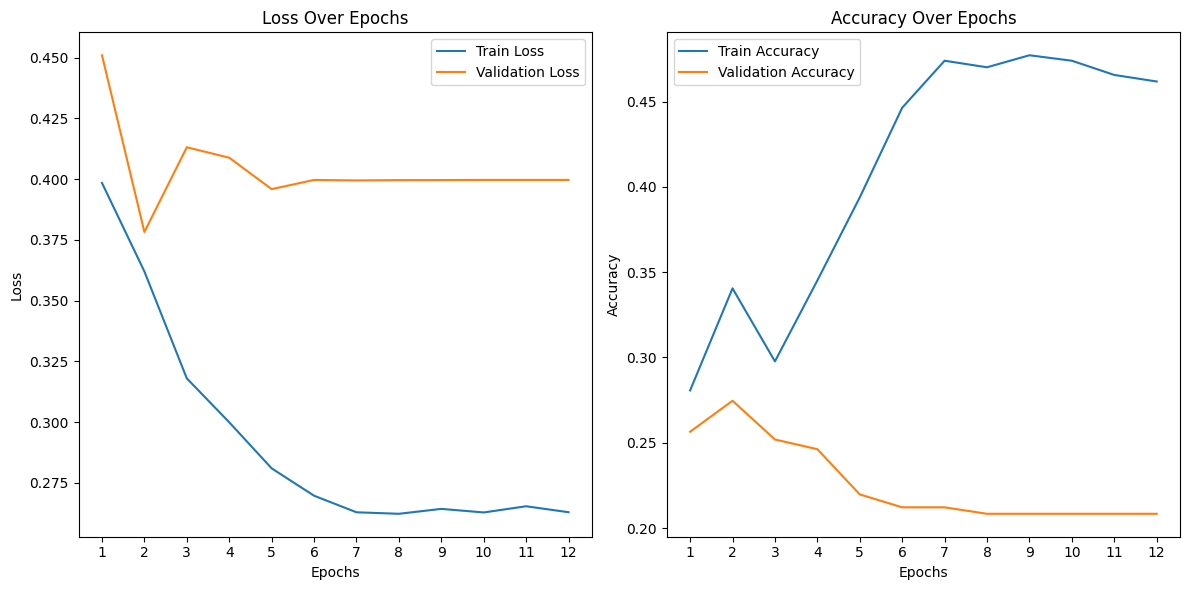

In [12]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):

    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xticks(range(1, len(epochs) + 1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xticks(range(1, len(epochs) + 1))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    # Anzeigen
    plt.tight_layout()
    plt.show()


plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [13]:
# Funktion zum Testen des Modells mit zusätzlichen Metriken
def evaluate_model(model, test_loader):
    model.eval()  # Setze das Modell in den Eval-Modus
    test_loss = 0.0
    test_labels = []
    test_preds = []

    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():  # Keine Gradientenberechnung für Test
        for batch in test_loader:
            tokens, labels = batch
            tokens, labels = tokens.to(device), labels.to(device)

            # Forward Pass
            outputs = model(tokens)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            probabilities = torch.sigmoid(outputs)
            threshold = 0.5
            test_preds += (probabilities >= threshold).cpu().int().numpy().tolist()
            test_labels += topics_onehot.cpu().int().numpy().tolist()

    # Berechne Metriken
    test_accuracy = jaccard_score(
        test_labels, test_preds, average="samples", zero_division=1
    )
    prec_recall = multilabel_precision_recall_curve(
        torch.tensor(test_preds), torch.tensor(test_labels), num_labels=len(topics)
    )
    # Ausgabe der Metriken
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    # print(f"Test PrecRec: {prec_recall}")

    return test_labels, test_preds


# Teste das Modell
test_labels, test_preds = evaluate_model(trained_model, test_loader)

Test Loss: 0.3642
Test Accuracy: 0.0739


### Results

**Hardware Specs:**
- CPU: AMD Ryzen 7 3700X 8-Core
- GPU: Nvidia GeForce RTX 3060 Ti
- RAM: 48GB
- OS: Linux Mint 22.1

**Training Results**

| Device | GRULayers | Dropout | EmbeddingDim | HiddenDim | VocabSize |    LR | Epoch | time/Epoch | TestAcc | TestF1 |
| ------ | --------: | ------: | -----------: | --------: | --------: | ----: | ----: | ---------- | ------- | ------ |
| Cuda   |         1 |       0 |          128 |       256 |     4.000 | 0.001 |       |            |         |        |